# How the White House Affects the Stock Market
### By Jon Khaykin and Richard Doan


In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.signal import wiener
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import matplotlib
%matplotlib inline  

import re

from bokeh.io import output_notebook, show
from bokeh.charts import Scatter, Line

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
#from pandas_ml import ConfusionMatrix

regex = re.compile('[^a-zA-Z ]')

def remove_duplicate_dates(df, value_text):
    cur_date = None
    vals = []
    dates = []
    for index, row in df.iterrows():
        if row['Date'] != cur_date:
            vals.append(row[value_text])
            dates.append(row['Date'])
            cur_date = row['Date']
    return pd.Series(vals), dates

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.extend([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words

def join_text_on_date(df):
    dates = [None]
    titles = []
    bodies = []
    fmp = []
    fmd = []
    for index, row in df.iterrows():
        if row['Date'] == dates[-1]:
            titles[-1] = titles[-1] + row['Title']
            bodies[-1] = bodies[-1] + row['Body']
        else:
            dates.append(row['Date'])
            fmp.append(row['Filtered Mean Proportion'])
            fmd.append(row['Filtered Mean Delta'])
            titles.append(row['Title'])
            bodies.append(row['Body'])
    return pd.DataFrame({'Date': dates[1:], 'Title': titles, 'Body': bodies, 
                         'Filtered Mean Proportion': fmp, 'Filtered Mean Delta': fmd})

def train_test_split(df):
    all_indices = np.arange(len(df))
    train_indices = np.random.choice(all_indices, 9 * len(all_indices) // 10)
    test_indices = np.setdiff1d(all_indices, train_indices)
    test_df = df.iloc[test_indices]
    df.iloc[test_indices].to_csv('data/dataset-test.csv', index=False)
    df.iloc[train_indices].to_csv('data/dataset-train.csv', index=False)

In [2]:
output_notebook()

Loading BokehJS ...

# Problem Statement

We are interested in understanding whether the White House Administration can influence how people feel about the economy. One good indicator of the economy's strength are the top index funds in the stock market: S&P 500, Nasdaq, and Dow Jones (each represents a good mix of businesses within many different industries). 

**Is there a correlation between White House announcements and movements in the stock market? And if there is, can we predict those movements based on the announcements?**

Other works that inspired this include the <a href="http://www.npr.org/2017/02/04/513469456/when-trump-tweets-this-bot-makes-money">twitter bot that traded based off of Donald Trump's tweets.</a> Perhaps there is a stronger correlation between White House announcements and what happens in the stock market. This approach will look at the White House as a primary medium of communication between the executive branch of the government and traders of the stock market. 

# The Corpus

Collecting just the blog posts for the corpus was quite easy: using BeautifulSoup, we scraped all the posts available from the <a href="https://www.whitehouse.gov/blog">White House Blog</a>. We first grabbed the date, title, and url of each page (10 posts per page). Then, we went through each url and scraped the body of each blog post. The date, title, and body were each added as a row to a CSV.

The aforementioned CSV was then used to get the financial info we wanted. We iterated through each row, grabbed the date, and used the yahoo finance library to calculate the proportion that the price changed (for each index fund) from the day the post was made to the next day. Now we had a CSV with date, title, body, and all the financial information we needed to do our analysis. Please see generate_dataset.py for all the code described in these paragraphs.

# Hypothesis

When campaigning, Trump promised that, if elected, he would <a href="http://www.cnbc.com/2016/09/16/trump-scales-back-tax-cuts-in-new-economic-plan.html">cut taxes</a>, <a href="http://fortune.com/2016/10/07/donald-trump-business-regulations/">dampen financial regulations</a>, and <a href="http://www.politico.com/story/2016/09/donald-trump-jobs-economic-plan-228218">bring back jobs to the U.S.</a>. Also, the election of Donald Trump caused a <a href="http://money.cnn.com/2017/01/20/investing/stock-market-trump-inauguration-day/">surge</a> in the market.

Therefore, not only will see that the administration is working on the promises made by President Trump, we will also:

1) find that the stock market moves a statistically significant amount when the administration makes any kind of economy-related announcements.
   
2) be able to predict whether the market will move based on an economy-related post.

In [3]:
df = pd.read_csv('data/dataset-train.csv').dropna()
df['Title'] = df['Title'].apply(lambda s: s + ' ')
df['Body'] = df['Body'].apply(lambda post: regex.sub('', post).lower())
df['Body'] = df['Body'].apply(lambda s: s + ' ')
df = df.sort_values(by='Date', ascending=False)

## Calculations
### Definitions
- $ND \triangleq $ NASDAQ
- $SP  \triangleq $ S&P 500
- $DJ  \triangleq $ Dow Jones
- $r_s(t) \triangleq $ closing price of stock $s$ at time $t$.

$Delta_s$ = $r_s(t+1) - r_s(t)$
- Mean Delta = $\frac{1}{3}\sum\limits_{s \in (ND, SP, DJ)} Delta_s$ 

$Proportion_s$ = $\frac{r_s(t+1) - r_s(t)}{r_s(t)}$ 
- Mean Proportion = $\frac{1}{3}\sum\limits_{s \in (ND, SP, DJ)} Proportion_s$ 



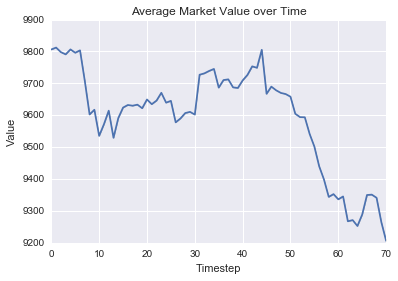

In [4]:
nasdaq_values = df[['Date','Nasdaq Value']]
sp_values = df[['Date','S&P 500 Value']]
dowjones_values = df[['Date','Dow Jones Value']]
nasdaq_values, dates = remove_duplicate_dates(nasdaq_values, 'Nasdaq Value')
sp_values, dates = remove_duplicate_dates(sp_values, 'S&P 500 Value')
dowjones_values, dates = remove_duplicate_dates(dowjones_values, 'Dow Jones Value')
mean_values = (nasdaq_values + dowjones_values + sp_values)/3
# sb.tsplot(nasdaq_values)
# sb.tsplot(dowjones_values)
# sb.tsplot(sp_values)
sb.tsplot(mean_values)
plt.title('Average Market Value over Time')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()

## Filtering Stock Market Data

Because we want to predict correlations between the stock market trend and White House blog posts, we decided to get rid of the inherent noise in our stock market data. This way, we eliminate the possibilty of fitting to the noise. The filter we decided to use was the Wiener filter with a sound-to-noise ratio derived from the variance of the stock market data.


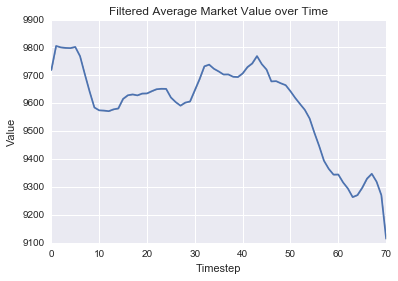

In [5]:
# Filter Values and Reassign
# Filter after averaging
filtered_mean_values = wiener(mean_values, noise=None)
mean_values_df = pd.DataFrame({'Filtered Mean Value': filtered_mean_values, 'Mean Value': mean_values,
                               'Date': dates})
mean_values_df['Filtered Mean Delta'] = -mean_values_df['Filtered Mean Value'].diff(periods=1)
mean_values_df['Mean Delta'] = -mean_values_df['Mean Value'].diff(periods=1)

nasdaq_delta = nasdaq_values.diff(periods=1)
sp_delta = sp_values.diff(periods=1)
dowjones_delta = dowjones_values.diff(periods=1)
mean_values_df['Filtered Mean Proportion'] =  (nasdaq_delta/nasdaq_values + sp_delta/sp_values 
                                               + dowjones_delta/dowjones_values)/3
mean_values_df['Mean Proportion'] = mean_values_df['Mean Delta'] / mean_values_df['Mean Value']

df = pd.merge(df, mean_values_df, on='Date', how='left').dropna()
sb.tsplot(filtered_mean_values)
plt.title('Filtered Average Market Value over Time')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()

## Processing the Input Data

Our data will consist of White House blog posts, which is unstructured text data. For our initial analysis, we want to see what topics are present, and if the topics are distinct enough, which topics are most correlated with stock market motions.

In [6]:
# Vectorize Blog Posts with BOW 
initial_vectorizer = CountVectorizer(stop_words='english', min_df=0.05, max_df=0.8)
data = initial_vectorizer.fit_transform(df['Body'])

In [7]:
distances = cosine_distances(data)
mds = MDS(n_components=2, dissimilarity='precomputed')
pos = mds.fit_transform(distances)

In [8]:
lda = LatentDirichletAllocation(n_topics=4, random_state=42, learning_method='online')
topic_scores = lda.fit_transform(data)
labels = np.argmax(topic_scores, axis=1)
df['Topic Label'] = labels

In [9]:
lda_df = {'x':pos[:, 0], 'y':pos[:,1], 'label':labels}
show(Scatter(lda_df, x='x', y='y', color='label', title='LDA Clusters - Trump'))

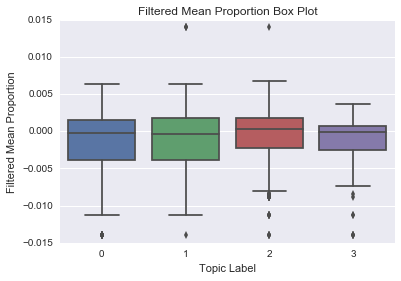

In [10]:
sb.boxplot(x="Topic Label", y="Filtered Mean Proportion", data=df)
plt.title('Filtered Mean Proportion Box Plot')
plt.show()

In [11]:
print_top_words(lda, initial_vectorizer.get_feature_names(), 20)


Topic 0:
order secretary united executive states federal law shall state security national agency department agencies director house policy office regulatory section

Topic 1:
think spicer going just thats people dont said im know theres mr administration question hes house sure make clear want

Topic 2:
trump united states american people america vice today minister donald security prime gorsuch americans economic country day national world women

Topic 3:
going thank great people american want applause know thats just right im country really good like jobs think mr say



All the top words per topic - aside from topic 0 - don't seem to have any easily identifiable topic. Let's look into the titles of topic 0.

In [12]:
df[df['Topic Label'] == 0]['Title']

9      President Donald J. Trump Approves Resighini R...
11                  Two Nominations Sent to the Senate  
13                  Two Nominations Sent to the Senate  
16                  Two Nominations Sent to the Senate  
21     Presidential Executive Order on the Establishm...
29     Presidential Executive Order Implementing an A...
30     Presidential Executive Order Implementing an A...
37     President Donald J. Trump Announces Key Additi...
40                    Photo of the Day: April 27, 2017  
43     Presidential Memorandum for the Secretary of C...
53     Presidential Executive Order on the Review of ...
56     Budgetary Impact Analysis for Executive Order ...
57     Presidential Executive Order on the Review of ...
62     List of Foreign Ambassadors Who Participated i...
67     President Trump's 100 Days of Historic Accompl...
71     Budgetary Impact Analysis for Executive Order ...
73     President Donald J. Trump Announces Intent to ...
75     President Donald J. Trum

Many of these do seem to be about regulations/money/budgets/etc. Look at 675-698!

In [13]:
topic_vectorizer = CountVectorizer(vocabulary=set(get_top_words(lda, initial_vectorizer.get_feature_names(), 50)))
data = topic_vectorizer.transform(df['Body'])

topic_df = pd.DataFrame(data.todense(), columns=topic_vectorizer.get_feature_names(), index=df.index)
vect_df = pd.concat([df, topic_df], axis=1)

X_train, X_test, y_train, y_test = tts(data.todense(), vect_df['Topic Label'])

rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       1.00      0.88      0.93        48
          1       1.00      1.00      1.00        20
          2       0.84      1.00      0.91        78
          3       1.00      0.72      0.84        32

avg / total       0.93      0.92      0.91       178



In [14]:
top0_mp = df[df['Topic Label'] == 0]['Filtered Mean Proportion']
topn0_mp = df[df['Topic Label'] != 0]['Filtered Mean Proportion']
ttest_ind(top0_mp, topn0_mp, equal_var=False)

Ttest_indResult(statistic=-2.1907741337498505, pvalue=0.029127654424823866)

We see a statstically significant difference between the Filtered Mean Proportions for topic 0 and all other topics.

Our classifier was able to predict which posts belong to which topics quite precisely using Random Forest. LDA was able to pick out the most prominent topics. It looks like topic 0 is the one we want to focus on, as it contains many articles that discuss some aspect of the economy. As hypothesized, the pvalue of the mean proportions is statiscally significant when compared to all other topics.

# Generating Feature Spaces

For us to be able to train a machine learning model on our text data, we must first structure our data into vector form. From the above topic labeling, we noticed that we could use the highest rated words from our LDA model to generate a dictionary. The idea here is to leverage the information the LDA model learned to reduce the noise in our feature space. Other methods we have tried include `difference of proportions` and `chi-squared rejection`. 

In [15]:
# Revectorize Blog Posts to Label each post with a topic
old_df = df
df = df[df['Topic Label'] == 0]
topic_vectorizer = CountVectorizer(vocabulary=set(get_top_words(lda, initial_vectorizer.get_feature_names(), 50)))
data = topic_vectorizer.transform(df['Body'])
distance = cosine_distances(data)
pos = mds.fit_transform(distance)

In [16]:
# Join the blog posts that are on the same day
joined_data_df = join_text_on_date(df)[['Date', 'Title', 'Body', 'Filtered Mean Delta', 'Filtered Mean Proportion']]
joined_data_df['Label'] = joined_data_df['Filtered Mean Proportion'].apply(lambda x: 1 if x >= 0 else 0)

In [17]:
# Vectorize them using BOW
# Can possibly try a word embeddings model to featurize our blogs
#vectorizer = CountVectorizer(stop_words='english', max_df=0.8, min_df=0.05)
X, y = topic_vectorizer.fit_transform(joined_data_df['Body']), joined_data_df['Label']
X_train, X_test, y_train, y_test = tts(X, y)

In [18]:
# Train Data Plot
distance = cosine_distances(X)
pos = mds.fit_transform(distance)
vis_df = pd.DataFrame({'x':pos[:,0], 'y':pos[:,1], 'label':y})
show(Scatter(vis_df, x='x', y='y', color='label', title='Labeled Feature Space'))

             precision    recall  f1-score   support

          0       0.67      0.67      0.67         9
          1       0.25      0.25      0.25         4

avg / total       0.54      0.54      0.54        13



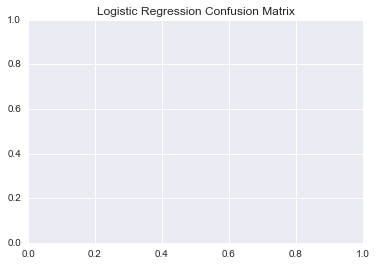

In [19]:
# Linear Model Attempt
log_reg = LogisticRegressionCV(Cs=20)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
report = classification_report(y_test, y_pred)
#cm = ConfusionMatrix(y_test, y_pred)

print(report)
#cm.plot(backend='seaborn')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

             precision    recall  f1-score   support

          0       0.75      0.33      0.46         9
          1       0.33      0.75      0.46         4

avg / total       0.62      0.46      0.46        13



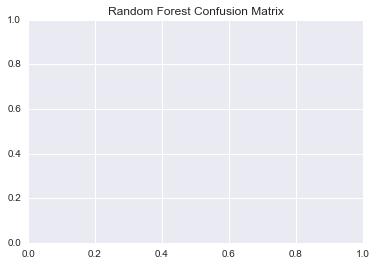

In [20]:
# Random Forest Attempt
rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
#cm = ConfusionMatrix(y_test, y_pred)

print(report)
#cm.plot(backend='seaborn')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Conclusions

While we were able to precisely classify posts into topics, we were unable to figure out a way to predict whether the market would move up or down given a post belongs to topic 0 (economy-related). We were able to find a significant difference in mean proportion change when comparing the economic topic to all the others. There seems to be something going on there but we were unable to pull it out. It may just be due to how LDA created the topics or some other factors of which we are unaware. It would be interesting to dive deeper into that and see why that difference exists.


When diving into the articles that make up the economy-related topic, we were unable to make effective predictions on what direction the posts would make the market move. Our lack of finding could be due to many reasons. For example, our design choices when determining the feature space could inhibit our ability to finding clusters. Another pitfall is our lack of data. Due to the fact that President Trump has only been in office a bit more than 100 days, we have a limited dataset with which to work.

It would be great to revisit this project a year in to Trump's presidency to see if we can get better results. 

In [ ]:
# Submit the data and notebook to Professor Nelson

# Further Investigation into Tweet Trader

In [ ]:
from datetime import datetime
from re import sub
tweets_data = pd.read_csv('data/trump_tweets.csv')

tweets_data['Date'] = tweets_data['Date'].apply(lambda s: datetime.strptime(s.split()[0], '%Y-%m-%d'))
tweets_data = tweets_data[tweets_data['Date'] > datetime.strptime('2016-12-25', '%Y-%m-%d')]
tweets_data['Date'] = tweets_data['Date'].apply(lambda s: datetime.strftime(s, '%Y-%m-%d'))
tweets_data = pd.merge(tweets_data, mean_values_df, on='Date', how='inner').dropna()

tweets_data['Text'] = tweets_data['Text'].str.replace('[^a-zA-Z ]', ' ').str.lower()tweets_data

In [ ]:
tweets_vectorizer = CountVectorizer(stop_words='english', min_df=0.01, max_df=0.8)
tweets_dtm = tweets_vectorizer.fit_transform(tweets_data['Text'])

In [ ]:
distances = cosine_distances(tweets_dtm)
mds = MDS(n_components=2, dissimilarity='precomputed')
pos = mds.fit_transform(distances)

In [ ]:
lda = LatentDirichletAllocation(n_topics=7, random_state=42, learning_method='online')
topic_scores = lda.fit_transform(tweets_dtm)
labels = np.argmax(topic_scores, axis=1)
tweets_data['Topic Label'] = labels

print_top_words(lda, tweets_vectorizer.get_feature_names(), 20)

lda_df = {'x':pos[:, 0], 'y':pos[:,1], 'label':labels}
show(Scatter(lda_df, x='x', y='y', color='label', title='LDA Clusters - Trump'))

It seems like everything but topic 2 seems interesting...

In [ ]:
sb.boxplot(x="Topic Label", y="Filtered Mean Proportion", data=tweets_data)
plt.title('Filtered Mean Proportion Box Plot')
plt.show()

In [ ]:
dates = [None]
text = []
fmp = []
fmd = []
for index, row in tweets_data.iterrows():
    if row['Topic Label'] == 2:
        continue
    if row['Date'] == dates[-1]:
        text[-1] = text[-1] + ' ' + row['Text']
    else:
        dates.append(row['Date'])
        fmp.append(row['Filtered Mean Proportion'])
        fmd.append(row['Filtered Mean Delta'])
        text.append(row['Text'])
        
tweets_df = pd.DataFrame({'Date': dates[1:], 'Text': text, 
                         'Filtered Mean Proportion': fmp, 'Filtered Mean Delta': fmd})[['Date', 'Text',
                                                                                        'Filtered Mean Proportion','Filtered Mean Delta']]
tweets_df['Label'] = tweets_df['Filtered Mean Proportion'].apply(lambda x: 1 if x >= 0 else 0)
tweets_df

In [ ]:
X, y = tweets_vectorizer.fit_transform(tweets_df['Text']), tweets_df['Label']
X_train, X_test, y_train, y_test = tts(X, y)

In [ ]:
distance = cosine_distances(X)
pos = mds.fit_transform(distance)
vis_df = pd.DataFrame({'x':pos[:,0], 'y':pos[:,1], 'label':y})
show(Scatter(vis_df, x='x', y='y', color='label', title='Labeled Feature Space'))

In [ ]:
# Linear Model Attempt
log_reg = LogisticRegressionCV(Cs=20)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
report = classification_report(y_test, y_pred)
cm = ConfusionMatrix(y_test, y_pred)

print(report)
cm.plot(backend='seaborn')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [ ]:
# Random Forest Attempt
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
cm = ConfusionMatrix(y_test, y_pred)

print(report)
cm.plot(backend='seaborn')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Twitter Bot Conclusion

Trump may have very pointed influence on with low frequency on the stock market as opposed to long term content based correlation.